In [1]:
#importing the required stuff
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime
import pandas as pd
import csv
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()




In [2]:
%matplotlib inline

In [3]:
# set number of assets (= number of qubits)
num_assets = 5
seed = 123

# Using data from yahoo finance
# use the name listed for particular company that you wish to add
data = YahooDataProvider(
        tickers=["AAPL","INTC","GOOG","MSFT","IBM"],
        start=datetime.datetime(2015, 9, 1),
        end=datetime.datetime(2021, 12, 1),
    )
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

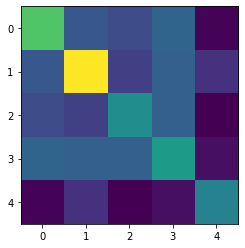

In [4]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()


In [5]:
q = 0.5  # set risk factor
budget = num_assets // 5  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.001349515637 x_0 - 0.000664322544 x_1 - 0.001105241391 x_2
      - 0.001499037956 x_3 - 0.000183849731 x_4 + [ 0.000339643640 x_0^2
      + 0.000404539310 x_0*x_1 + 0.000382632738 x_0*x_2 + 0.000435549968 x_0*x_3
      + 0.000248020306 x_0*x_4 + 0.000420816739 x_1^2 + 0.000356761958 x_1*x_2
      + 0.000427146528 x_1*x_3 + 0.000328640375 x_1*x_4 + 0.000268201090 x_2^2
      + 0.000427082711 x_2*x_3 + 0.000242628080 x_2*x_4 + 0.000284701211 x_3^2
      + 0.000268003222 x_3*x_4 + 0.000254636495 x_4^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 + x_4 = 1

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4
End

In [31]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x

import csv
   
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

with open('test.csv', 'w') as csvfile:
    header = ['Selection', 'Value', 'Probability']
    writer = csv.writer(csvfile, delimiter=' ')
    writer.writerow(header)
        
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        writer.writerow([x, value, probability])
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))
        
        
csvfile.close()


----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 0]	-0.0005		0.2793
[0 0 0 0 1]	-0.0001		0.2792
[1 0 0 0 0]	-0.0012		0.2638
[0 0 1 0 0]	-0.0010		0.1776
[0 0 1 0 1]	1.0064		0.0001
[1 1 0 0 0]	1.0059		0.0000
[0 1 0 0 1]	1.0070		0.0000
[1 0 1 0 0]	1.0054		0.0000
[1 0 0 1 0]	1.0050		0.0000
[0 1 1 0 0]	1.0061		0.0000
[0 0 1 1 0]	1.0052		0.0000
[0 0 0 1 0]	-0.0014		0.0000
[0 1 0 1 0]	1.0057		0.0000
[1 1 1 0 0]	4.0274		0.0000
[1 0 1 1 0]	4.0265		0.0000
[1 0 1 0 1]	4.0276		0.0000
[0 0 0 0 0]	1.0073		0.0000
[0 1 1 1 1]	9.0643		0.0000
[0 0 0 1 1]	1.0061		0.0000
[1 0 0 0 1]	1.0062		0.0000
[0 1 1 0 1]	4.0284		0.0000
[0 0 1 1 1]	4.0275		0.0000
[1 0 0 1 1]	4.0273		0.0000
[1 1 1 1 0]	9.0634		0.0000
[0 1 0 1 1]	4.0280		0.0000
[0 1 1 1 0]	4.0272		0.0000
[1 1 1 1 1]	16.1153		0.0000
[1 1 0 0 1]	4.0282		0.0000
[1 1 0 1 1]	9.0641		0.0000
[1 1 0 1 0]	4.0270		0.0000
[1 1 1 0 1]	9.0644		0.0000
[1 0 1 1 1]	9.0636		0.0

In [32]:
%%time

#classical reference solution

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)



Optimal: selection [0. 0. 0. 1. 0.], value -0.0014
CPU times: user 28.6 ms, sys: 4.31 ms, total: 32.9 ms
Wall time: 28.6 ms


In [33]:
%%time

# VQE solution

from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=1000)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=10000, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)
    

Optimal: selection [0. 0. 0. 1. 0.], value -0.0014
CPU times: user 3.14 s, sys: 127 ms, total: 3.26 s
Wall time: 3.25 s


In [34]:
%%time

# QAOA solution

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=1000)
quantum_instance = QuantumInstance(backend=backend, shots=10000, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)


Optimal: selection [0. 0. 0. 1. 0.], value -0.0014
CPU times: user 3.99 s, sys: 134 ms, total: 4.12 s
Wall time: 4.11 s
